### Imports and set path to local mavenn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import logomaker
import matplotlib.gridspec as gridspec
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
from scipy.stats import norm
from matplotlib.colors import TwoSlopeNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/'
sys.path.insert(0,path_to_mavenn)

# Load mavenn
import mavenn

In [2]:
mavenn.__path__

['/Users/jkinney/github/mavenn/mavenn']

In [3]:
style_file_name = 'fig5.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
lines.dash_capstyle:   round        # {butt, round, projecting}
lines.solid_capstyle:   round        # {butt, round, projecting}
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [4]:
def _get_45deg_mesh(mat):
    """Create X and Y grids rotated -45 degreees."""
    # Define rotation matrix
    theta = -np.pi / 4
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])

    # Define unrotated coordinates on
    K = len(mat) + 1
    grid1d = np.arange(0, K) - .5
    X = np.tile(np.reshape(grid1d, [K, 1]), [1, K])
    Y = np.tile(np.reshape(grid1d, [1, K]), [K, 1])
    xy = np.array([X.ravel(), Y.ravel()])

    # Rotate coordinates
    xy_rot = R @ xy
    X_rot = xy_rot[0, :].reshape(K, K)
    Y_rot = xy_rot[1, :].reshape(K, K).T

    return X_rot, Y_rot

def heatmap_pairwise(values,
                     alphabet,
                     seq=None,
                     seq_kwargs=None,
                     ax=None,
                     gpmap_type="pairwise",
                     show_position=False,
                     position_size=None,
                     position_pad=1,
                     show_alphabet=True,
                     alphabet_size=None,
                     alphabet_pad=1,
                     show_seplines=True,
                     sepline_kwargs=None,
                     xlim_pad=.1,
                     ylim_pad=.1,
                     cbar=True,
                     cax=None,
                     clim=None,
                     clim_quantile=1,
                     ccenter=0,
                     cmap='coolwarm',
                     cmap_size="5%",
                     cmap_pad=0.1):
    """
    Draw a heatmap illustrating pairwise or neighbor values, e.g. representing
    model parameters, mutational effects, etc.

    Note: The resulting plot has aspect ratio of 1 and is scaled so that pixels
    have half-diagonal lengths given by ``half_pixel_diag = 1/(C*2)``, and
    blocks of characters have half-diagonal lengths given by
    ``half_block_diag = 1/2``. This is done so that the horizontal distance
    between positions (as indicated by x-ticks) is 1.

    Parameters
    ----------
    values: (np.array)
        An array, shape ``(L,C,L,C)``, containing pairwise or neighbor values.
        Note that only values at coordinates ``[l1, c1, l2, c2]`` with
        ``l2`` > ``l1`` will be plotted. NaN values will not be plotted.

    alphabet: (str, np.ndarray)
        Alphabet name ``'dna'``, ``'rna'``, or ``'protein'``, or 1D array
        containing characters in the alphabet.

    seq: (str, None)
        The sequence to show, if any, using dots plotted on top of the heatmap.
        Must have length ``L`` and be comprised of characters in ``alphabet``.

    seq_kwargs: (dict)
        Arguments to pass to ``Axes.scatter()`` when drawing dots to illustrate
        the characters in ``seq``.

    ax: (matplotlib.axes.Axes)
        The ``Axes`` object on which the heatmap will be drawn.
        If ``None``, one will be created. If specified, ``cbar=True``,
        and ``cax=None``, ``ax`` will be split in two to make room for a
        colorbar.

    gpmap_type: (str)
        Determines how many pairwise parameters are plotted.
        Must be ``'pairwise'`` or ``'neighbor'``. If ``'pairwise'``, a
        triangular heatmap will be plotted. If ``'neighbor'``, a heatmap
        resembling a string of diamonds will be plotted.

    show_position: (bool)
        Whether to annotate the heatmap with position labels.

    position_size: (float)
        Font size to use for position labels. Must be >= 0.

    position_pad: (float)
        Additional padding, in units of ``half_pixel_diag``, used to space
        the position labels further from the heatmap.

    show_alphabet: (bool)
        Whether to annotate the heatmap with character labels.

    alphabet_size: (float)
        Font size to use for alphabet. Must be >= 0.

    alphabet_pad: (float)
        Additional padding, in units of ``half_pixel_diag``, used to space
        the alphabet labels from the heatmap.

    show_seplines: (bool)
        Whether to draw lines separating character blocks for different
        position pairs.

    sepline_kwargs: (dict)
        Keywords to pass to ``Axes.plot()`` when drawing seplines.

    xlim_pad: (float)
        Additional padding to add (in absolute units) both left and right of
        the heatmap.

    ylim_pad: (float)
        Additional padding to add (in absolute units) both above and below the
        heatmap.

    cbar: (bool)
        Whether to draw a colorbar next to the heatmap.

    cax: (matplotlib.axes.Axes, None)
        The ``Axes`` object on which the colorbar will be drawn, if requested.
        If ``None``, one will be created by splitting ``ax`` in two according
        to ``cmap_size`` and ``cmap_pad``.

    clim: (list, None)
        List of the form ``[cmin, cmax]``, specifying the maximum ``cmax``
        and minimum ``cmin`` values spanned by the colormap. Overrides
        ``clim_quantile``.

    clim_quantile: (float)
        Must be a float in the range [0,1]. ``clim`` will be automatically
        chosen to include this central quantile of values.

    ccenter: (float)
        Value at which to position the center of a diverging
        colormap. Setting ``ccenter=0`` often makes sense.

    cmap: (str, matplotlib.colors.Colormap)
        Colormap to use.

    cmap_size: (str)
        Fraction of ``ax`` width to be used for the colorbar. For formatting
        requirements, see the documentation for
        ``mpl_toolkits.axes_grid1.make_axes_locatable()``.

    cmap_pad: (float)
        Space between colorbar and the shrunken heatmap ``Axes``. For formatting
        requirements, see the documentation for
        ``mpl_toolkits.axes_grid1.make_axes_locatable()``.

    Returns
    -------
    ax: (matplotlib.axes.Axes)
        ``Axes`` object containing the heatmap.

    cb: (matplotlib.colorbar.Colorbar, None)
        Colorbar object linked to ``ax``, or ``None`` if no colorbar was drawn.
    """
    L, C, L2, C2 = values.shape
    values = values.copy()

    ls = np.arange(L).astype(int)
    l1_grid = np.tile(np.reshape(ls, (L, 1, 1, 1)),
                      (1, C, L, C))
    l2_grid = np.tile(np.reshape(ls, (1, 1, L, 1)),
                      (L, C, 1, C))

    # If user specifies gpmap_type="neighbor", remove non-neighbor entries
    if gpmap_type == "neighbor":
        nan_ix = ~(l2_grid - l1_grid == 1)

    # Don't do anything if gpmap_type="pairwise"
    elif gpmap_type == "pairwise":
        nan_ix = ~(l2_grid - l1_grid >= 1)

    # Set values at invalid positions to nan
    values[nan_ix] = np.nan

    # Reshape values into a matrix
    mat = values.reshape((L*C, L*C))
    mat = mat[:-C, :]
    mat = mat[:, C:]
    K = (L - 1) * C

    # Verify that mat is the right size
    assert mat.shape == (K, K), \
        f'mat.shape={mat.shape}; expected{(K,K)}. Should never happen.'

    # Get indices of finite elements of mat
    ix = np.isfinite(mat)

    # Set color lims to central 95% quantile
    if clim is None:
        clim = np.quantile(mat[ix], q=[(1 - clim_quantile) / 2,
                                    1 - (1 - clim_quantile) / 2])

    # Create axis if none already exists
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Needed to center colormap at zero
    if ccenter is not None:

        # Reset ccenter if is not compatible with clim
        if (clim[0] > ccenter) or (clim[1] < ccenter):
            ccenter = 0.5 * (clim[0] + clim[1])

        norm = TwoSlopeNorm(vmin=clim[0], vcenter=ccenter, vmax=clim[1])

    else:
        norm = Normalize(vmin=clim[0], vmax=clim[1])

    # Get rotated mesh
    X_rot, Y_rot = _get_45deg_mesh(mat)

    # Normalize
    half_pixel_diag = 1 / (2*C)
    pixel_side = 1 / (C * np.sqrt(2))
    X_rot = X_rot * pixel_side + half_pixel_diag
    Y_rot = Y_rot * pixel_side


    # Set parameters that depend on gpmap_type
    ysep_min = -0.5 - .001 * half_pixel_diag
    xlim = [-xlim_pad, L - 1 + xlim_pad]
    if gpmap_type == "pairwise":
        ysep_max = L / 2 + .001 * half_pixel_diag
        ylim = [-0.5 - ylim_pad, (L - 1) / 2 + ylim_pad]
    else:
        ysep_max = 0.5 + .001 * half_pixel_diag
        ylim = [-0.5 - ylim_pad, 0.5 + ylim_pad]

    # Not sure why I have to do this
    Y_rot = -Y_rot

    # Draw rotated heatmap
    im = ax.pcolormesh(X_rot,
                       Y_rot,
                       mat,
                       cmap=cmap,
                       norm=norm)

    # Remove spines
    for loc, spine in ax.spines.items():
        spine.set_visible(False)

    # Set sepline kwargs
    if show_seplines:
        if sepline_kwargs is None:
            sepline_kwargs = {'color': 'gray',
                              'linestyle': '-',
                              'linewidth': .5}

        # Draw white lines to separate position pairs
        for n in range(0, K+1, C):

            # TODO: Change extent so these are the right length
            x = X_rot[n, :]
            y = Y_rot[n, :]
            ks = (y >= ysep_min) & (y <= ysep_max)
            ax.plot(x[ks], y[ks], **sepline_kwargs)

            x = X_rot[:, n]
            y = Y_rot[:, n]
            ks = (y >= ysep_min) & (y <= ysep_max)
            ax.plot(x[ks], y[ks], **sepline_kwargs)

    # Set lims
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set aspect
    ax.set_aspect("equal")

    # Remove yticks
    ax.set_yticks([])

    # Set xticks
    xticks = np.arange(L).astype(int)
    ax.set_xticks(xticks)

    # If drawing characters
    if show_alphabet:

        # Draw c1 alphabet
        for i, c in enumerate(alphabet):
            x1 = 0.5 * half_pixel_diag \
                 + i * half_pixel_diag \
                 - alphabet_pad * half_pixel_diag
            y1 = - 0.5 * half_pixel_diag \
                 - i * half_pixel_diag \
                 - alphabet_pad * half_pixel_diag
            ax.text(x1, y1, c, va='center',
                    ha='center', rotation=-45, fontsize=alphabet_size)

        # Draw c2 alphabet
        for i, c in enumerate(alphabet):
            x2 = 0.5 + 0.5 * half_pixel_diag \
                 + i * half_pixel_diag \
                 + alphabet_pad * half_pixel_diag
            y2 = - 0.5 + 0.5 * half_pixel_diag \
                 + i * half_pixel_diag \
                 - alphabet_pad * half_pixel_diag
            ax.text(x2, y2, c, va='center',
                    ha='center', rotation=45, fontsize=alphabet_size)

    # Display positions if requested (only if model is pairwise)
    l1_positions = np.arange(0, L-1)
    l2_positions = np.arange(1, L)
    half_block_diag = C * half_pixel_diag
    if show_position and gpmap_type == "pairwise":

        # Draw l2 positions
        for i, l2 in enumerate(l2_positions):
            x2 = 0.5 * half_block_diag \
                 + i * half_block_diag \
                 - position_pad * half_pixel_diag
            y2 = 0.5 * half_block_diag \
                 + i * half_block_diag \
                 + position_pad * half_pixel_diag
            ax.text(x2, y2, f'{l2:d}', va='center',
                    ha='center', rotation=45, fontsize=position_size)

        # Draw l1 positions
        for i, l1 in enumerate(l1_positions):
            x1 = (L - 0.5) * half_block_diag \
                 + i * half_block_diag \
                 + position_pad * half_pixel_diag
            y1 = (L - 1.5) * half_block_diag \
                 - i * half_block_diag \
                 + position_pad * half_pixel_diag
            ax.text(x1, y1, f'{l1:d}', va='center',
                    ha='center', rotation=-45, fontsize=position_size)

    elif show_position and gpmap_type == "neighbor":

        # Draw l2 positions
        for i, l2 in enumerate(l2_positions):
            x2 = 0.5 * half_block_diag \
                 + 2 * i * half_block_diag \
                 - position_pad * half_pixel_diag
            y2 = 0.5 * half_block_diag \
                 + position_pad * half_pixel_diag
            ax.text(x2, y2, f'{l2:d}', va='center',
                    ha='center', rotation=45, fontsize=position_size)

        # Draw l1 positions
        for i, l1 in enumerate(l1_positions):
            x1 = 1.5 * half_block_diag \
                 + 2* i * half_block_diag \
                 + position_pad * half_pixel_diag
            y1 = + 0.5 * half_block_diag \
                 + position_pad * half_pixel_diag
            ax.text(x1, y1, f'{l1:d}', va='center',
                    ha='center', rotation=-45, fontsize=position_size)

    # Mark wt sequence
    if seq:

        # Set seq_kwargs if not set in constructor
        if seq_kwargs is None:
            seq_kwargs = {'marker': '.', 'color': 'k', 's': 2}

        # Iterate over pairs of positions
        for l1 in range(L):
            for l2 in range(l1+1, L):

                # Break out of loop if gmap_type is "neighbor" and l2 > l1+1
                if (l2-l1 > 1) and gpmap_type == "neighbor":
                    continue

                # Iterate over pairs of characters
                for i1, c1 in enumerate(alphabet):
                    for i2, c2 in enumerate(alphabet):

                        # If there is a match to the wt sequence,
                        if seq[l1] == c1 and seq[l2] == c2:

                            # Compute coordinates of point
                            x = half_pixel_diag + \
                                (i1 + i2) * half_pixel_diag + \
                                (l1 + l2 - 1) * half_block_diag
                            y = (i2 - i1) * half_pixel_diag + \
                                (l2 - l1 - 1) * half_block_diag

                            # Plot point
                            ax.scatter(x, y, **seq_kwargs)


    # Create colorbar if requested, make one
    if cbar:
        if cax is None:
            cax = make_axes_locatable(ax).new_horizontal(size=cmap_size,
                                                         pad=cmap_pad)
            fig.add_axes(cax)
        cb = plt.colorbar(im, cax=cax)

        # Otherwise, return None for cb
    else:
        cb = None

    return ax, cb

In [5]:
models = {}

models['additive'] = mavenn.load('fig5_models/mpsa_additive_ge_2021.12.28.13h.35m')
models['neighbor']= mavenn.load('fig5_models/mpsa_neighbor_ge_2021.12.28.13h.35m')
models['pairwise'] = mavenn.load('fig5_models/mpsa_pairwise_ge_2021.12.28.16h.07m')
models['blackbox'] = mavenn.load('fig5_models/mpsa_blackbox_ge_2021.12.28.13h.36m')

Model loaded from these files:
	fig5_models/mpsa_additive_ge_2021.12.28.13h.35m.pickle
	fig5_models/mpsa_additive_ge_2021.12.28.13h.35m.h5
Model loaded from these files:
	fig5_models/mpsa_neighbor_ge_2021.12.28.13h.35m.pickle
	fig5_models/mpsa_neighbor_ge_2021.12.28.13h.35m.h5
Model loaded from these files:
	fig5_models/mpsa_pairwise_ge_2021.12.28.16h.07m.pickle
	fig5_models/mpsa_pairwise_ge_2021.12.28.16h.07m.h5
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model loaded from these files:
	fig5_models/mpsa_blackbox_ge_2021.12.28.13h.36m.pickle
	fig5_models/mpsa_blackbox_ge_2021.12.28.13h.36m.h5


In [6]:
np.random.seed(0)

# Load example data 
data_df = mavenn.load_example_dataset('mpsa')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

x_test = test_df['x'].values
y_test = test_df['y'].values

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 6,078
training + validation N: 24,405


,set,tot_ct,ex_ct,y,x
0,training,28,2,0.023406,GGAGUGAUG
1,training,193,15,-0.074999,UUCGCGCCA
2,training,27,0,-0.438475,UAAGCUUUU
3,training,130,2,-0.631467,AUGGUCGGG
4,training,552,19,-0.433012,AGGGCAGGA
5,training,216,6,-0.482679,GGUGUCUGU
6,validation,88,4,-0.241737,CAGGCAAAC
7,training,14,0,-0.167408,CAUGCAGCU
8,training,170,14,-0.048222,CAAGUCACU
9,training,242,13,-0.230795,UCCGCGCUA


In [7]:
info_dict = {}

info_dict['additive\n(epistasis package)','$I_{\\rm var}$'] = {'I':0.000000,'dI':0.000000}
info_dict['additive\n(epistasis package)','$I_{\\rm pred}$'] = {'I':0.220371,'dI':0.012467}

for model_name,model in models.items():
    
    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
    
    info_dict[model_name,'$I_{\\rm var}$']  = {'I':I_var,'dI':dI_var}
    info_dict[model_name,'$I_{\\rm pred}$'] = {'I':I_pred,'dI':dI_pred} 

In [8]:
info_df = pd.DataFrame(info_dict).T
info_df = info_df[['I','dI']].reset_index().copy()
info_df.rename(columns={'level_0':'name'}, inplace=True)
info_df.loc[8:10,'name'] = 'black box'

In [9]:
info_df

,name,level_1,I,dI
0,additive\n(epistasis package),$I_{\rm var}$,0.000000,0.000000
1,additive\n(epistasis package),$I_{\rm pred}$,0.220371,0.012467
2,additive,$I_{\rm var}$,0.199333,0.026173
3,additive,$I_{\rm pred}$,0.220436,0.009836
4,neighbor,$I_{\rm var}$,0.307338,0.029280
5,neighbor,$I_{\rm pred}$,0.330003,0.015334
6,pairwise,$I_{\rm var}$,0.289075,0.025270
7,pairwise,$I_{\rm pred}$,0.367334,0.014729
8,black box,$I_{\rm var}$,0.422204,0.025528
9,black box,$I_{\rm pred}$,0.442955,0.014197


In [10]:
I_rep = 0.46067406

In [11]:
# load Sailer-Harms inference data
fig5npz = np.load('fig5_SH_data/fig5_data_dict.npz')
phi_sh = fig5npz['phi_sh']
yhat_sh = fig5npz['yhat_sh']
y_sh = fig5npz['y_sh']
phi_grid_sh=fig5npz['phi_grid_sh']
yhat_grid_sh = fig5npz['yhat_grid_sh']

I_epistasis: 0.220 +- 0.012 bits
I_mavenn: 0.220 +- 0.010 bits
z: 0.00
p-value: 0.4984


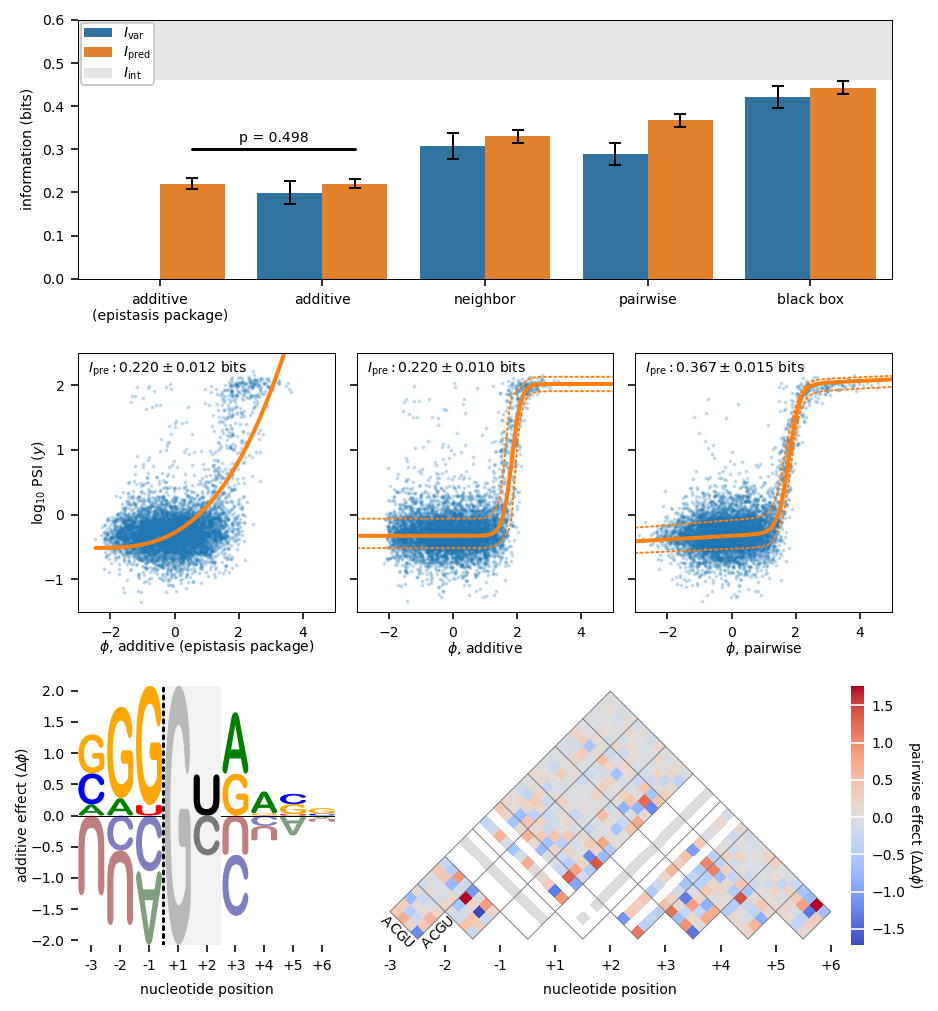

In [12]:
fig = plt.figure(figsize=[6.5, 7])
gs = gridspec.GridSpec(3, 3, figure=fig)
# Set lims and ticks
ylim = [-2.5, 2.5]
yticks = [-6,-4,-2,0,2,4]
philim = [-3,5]
phiticks = [-2,0,2,4]

#
# Panel A: Bar chart
#
ax = fig.add_subplot(gs[0,:])

# Plot I_int region
K = len(info_df)
xlim = [-.5, 4.5]
ylim = [0, 0.6]
ax.fill_between(xlim, [I_rep, I_rep], [.6, .6], color='gray', alpha=.2, zorder=-100, linewidth=0,
                label='$I_\mathrm{int}$')
# ax.axhline(I_rep, color='C2', linestyle='--', linewidth=1, zorder=-10, 
#            label='$I_\mathrm{int}$ (lower bound)')

# Plot bars
sns.barplot(ax=ax, data=info_df, hue='level_1', x='name', y='I')

# Plot 95% confidence intervals
x = np.array([[x-.2,x+.2] for x in range(5)]).ravel()
yerr = info_df['dI'].values
y = info_df['I'].values 
ax.errorbar(x=x[1:], y=y[1:], yerr=yerr[1:], color='k', capsize=3, linestyle='none', 
            elinewidth=1, capthick=1, solid_capstyle='round')
ax.set_ylabel('information (bits)')
#ax.set_xlabel('G-P map type')
ax.set_xlabel('')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
#ax.legend(loc='upper left')

# Reorder legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[2], handles[0]]
labels = [labels[1], labels[2], labels[0]]
ax.legend(handles, labels, loc='upper left')

# Compute a p-value for additive epistasis vs. MAVE-NN I_pred
I_epistasis = info_df.loc[1,'I']
dI_epistasis = info_df.loc[1,'dI']
print(f'I_epistasis: {I_epistasis:.3f} +- {dI_epistasis:.3f} bits')

I_mavenn = info_df.loc[3,'I']
dI_mavenn = info_df.loc[3,'dI']
print(f'I_mavenn: {I_mavenn:.3f} +- {dI_mavenn:.3f} bits')

z = (I_mavenn - I_epistasis)/np.sqrt(dI_epistasis**2 + dI_mavenn**2)
print(f'z: {z:.2f}')

dist = norm()
p = norm.cdf(-z)
print(f'p-value: {p:.4f}')

# Plot significance line
ax.plot([0.2, 1.2], [.3, .3], '-k')

# Plot text 
ax.text(x=.7, y=.31, s=f'p = {p:.3f}', ha='center', va='bottom')

# x_test = test_df['x']
# y_test = test_df['y']

# #
# # Panel B: GE plot for Sailer & Harms model
# #

ylim = [-1.5, 2.5]
yticks = [-1, 0, 1, 2]

# Show results from Sailer & Harms
# Set ax
ax = fig.add_subplot(gs[1,0])

ax.scatter(phi_sh, 
           y_sh, 
           s=1,
           alpha=.2,
           color='C0')

ax.plot(phi_grid_sh, 
        yhat_grid_sh, 
        color='C1', 
        alpha=1, 
        linestyle='-', 
        linewidth=2, 
        label='$\hat{y}$')

# Style plot
ax.set_xlim(philim)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_xlabel(f'$\phi$, additive (epistasis package)', labelpad=-1)
ax.set_ylabel('$\log_{10}$ PSI ($y$)', labelpad=-2)
#ax.legend(loc='lower right')

# Show information in title
#ax.set_title(f'$I_\mathrm{{pre}}={I_epistasis:.3f}\pm{dI_epistasis:.3f}$ bits')
ax.text(x=-2.7, y=2.4, fontsize=7, ha='left', va='top',
        s=f'$I_\mathrm{{pre}}: {I_epistasis:.3f}\pm{dI_epistasis:.3f}$ bits');

# #
# # Panel C,D: GE plots for MAVE-NN models
# #

# # Choose phi grid for plotting curves
# phi_grid = np.linspace(philim[0],philim[1], 1000)

# info_sub_df = info_df.loc[[3,7],:].reset_index()

for i, name in enumerate(['additive', 'pairwise']):
    
    # Set ax
    ax = fig.add_subplot(gs[1,i+1])
    mpsa_model = models[name]
    phi = mpsa_model.x_to_phi(x_test)
    
    phi_grid = np.linspace(philim[0], philim[1], 1000)
    yhat_grid = mpsa_model.phi_to_yhat(phi_grid)
    yqs_grid = mpsa_model.yhat_to_yq(yhat_grid, q=[.16,.84])
    I_pred = info_df[info_df['name']==name].reset_index(drop=True)['I'][1]
    dI_pred = info_df[info_df['name']==name].reset_index(drop=True)['dI'][1]

    # Draw scatter plot
    ax.scatter(phi, 
               y_test, 
               s=1,
               alpha=.2,
               color='C0')

    # Draw GE curve & confidence intervals
    ax.plot(phi_grid, 
            yhat_grid, 
            color='C1', 
            alpha=1, 
            linestyle='-', 
            linewidth=2, 
            label='$\hat{y}$')
    ax.plot(phi_grid, 
            yqs_grid[:,0], 
            color='C1', 
            alpha=1, 
            linestyle=':', 
            linewidth=1, 
            label='95% CI')
    ax.plot(phi_grid, 
            yqs_grid[:,1], 
            color='C1', 
            alpha=1, 
            linestyle=':', 
            linewidth=1)
    
    #ax.text(x=-2, y=4, s=f'$I_\mathrm{{pred}}={I_pred:.2f}\pm{dI_pred:.2f}$ bits', va='center', ha='left')
    #ax.set_title(f'$I_\mathrm{{pre}}={I_pred:.3f}\pm{dI_pred:.3f}$ bits')
    ax.text(x=-2.7, y=2.4, fontsize=7, ha='left', va='top',
        s=f'$I_\mathrm{{pre}}: {I_pred:.3f}\pm{dI_pred:.3f}$ bits');
    
    #ax.legend(loc='lower right')
    
    # Style plot
    ax.set_xlim(philim)
    ax.set_ylim(ylim)
    ax.set_yticks(yticks)
    ax.set_yticklabels([])
    ax.set_xlabel(f'$\phi$, {name}', labelpad=0)
    #ax.set_ylabel('$\log_{10}$ PSI ($y$)')

# Draw logo
ax = fig.add_subplot(gs[2,0])
logo_df = models['pairwise'].get_theta()['logomaker_df'].fillna(0)
logo = logomaker.Logo(df=logo_df, ax=ax, fade_below=.5, shade_below=.5, width=.9, font_name='Arial Rounded MT Bold')
ylim = ax.get_ylim()
logo.highlight_position_range(pmin=3, pmax=4, color='w', alpha=1, zorder=10)
logo.highlight_position_range(pmin=3, pmax=4, color='gray', alpha=.1, zorder=11)
logo.style_single_glyph(p=3, c='G', floor=ylim[0], ceiling=ylim[1], color='gray', zorder=30, alpha=.5)
logo.style_single_glyph(p=4, c='U', color='k', zorder=30)
logo.style_single_glyph(p=4, c='C', color='k', zorder=30)
logo.style_spines(visible=False)
ax.axvline(2.5, linestyle=':', color='k', zorder=30)
#ax.set_yticks([])
ax.set_ylabel('additive effect ($\Delta \phi$)', labelpad=-1)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
ax.set_xlabel('nucleotide position', labelpad=5)

# Draw heatmap
ax = fig.add_subplot(gs[2,-2:])
theta = models['pairwise'].get_theta()['theta_lclc']
ax, cb = heatmap_pairwise(values=theta,
                          alphabet='ACGU',
                          ax=ax,
                          gpmap_type='pairwise',
                          cmap_size='3%')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
ax.set_xlabel('nucleotide position', labelpad=5)
cb.set_label('pairwise effect ($\Delta \Delta \phi$)', labelpad=5, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=10, color='white')
#cb.set_ticks([-1, -.5, 0, .5])


# # Clean up plots and save
fig.tight_layout(h_pad=2)
fig.savefig('fig5_ipynb.png',dpi=400,facecolor='w')

In [18]:
models['blackbox'].arg_dict

{'L': 9,
 'alphabet': 'rna',
 'regression_type': 'GE',
 'gpmap_type': 'blackbox',
 'gpmap_kwargs': {'hidden_layer_sizes': (10, 10, 10, 10, 10),
  'features': 'pairwise'},
 'Y': 2,
 'ge_nonlinearity_type': 'nonlinear',
 'ge_nonlinearity_monotonic': True,
 'ge_nonlinearity_hidden_nodes': 50,
 'ge_noise_model_type': 'SkewedT',
 'ge_heteroskedasticity_order': 2,
 'normalize_phi': True,
 'mpa_hidden_nodes': 50,
 'theta_regularization': 0.001,
 'eta_regularization': 0.1,
 'ohe_batch_size': 50000,
 'custom_gpmap': None,
 'initial_weights': None}